In [1]:
import pickle

import pandas as pd
import weave
from IPython.display import display, Markdown

from ydnpd.agent.specifications import *
from ydnpd.agent.utils import produce_datasets
from ydnpd.datasets import load_dataset, mix_datasets, mix_datasets, plot_distribution_distances, plot_dataset_selection, compare_datasets
from ydnpd.utils import metadata_to_pandera_schema
from ydnpd.harness import ALL_EXPERIMENTS

# weave.init("ydnpd-data_gen_agent")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
PRIVATE_DATASET = "acs/national"
FAMILY, _ = PRIVATE_DATASET.split("/")
NUM_SAMPLES = len(load_dataset(PRIVATE_DATASET)[0])
METADATA_PANDERA = metadata_to_pandera_schema(load_dataset(PRIVATE_DATASET)[1])

NUM_DATASETS = 10
LLM_NAMES = ["gpt-4o-mini", "gpt-4o"]  # "o1-mini", "o1-preview"
SPECIFICATIONS = [SPECIFICATION_V1] #  SPECIFICATION_V0, SPECIFICATION_V01, SPECIFICATION_V02, SPECIFICATION_V03,
TEMPERATURES = [0.3, 0.7, 1] #, 1] # [0.7]  # [0, 0.35, 0.7]

In [3]:
# results = []

# for specificaion_version, specification in enumerate(SPECIFICATIONS):

#     for llm_name in LLM_NAMES:

#         for llm_temperature in TEMPERATURES:
            
#             if specificaion_version == 1 and "o1-" in llm_name:
#                 continue

#             llm_kwargs = {"llm_name": llm_name,
#                           "llm_temperature": llm_temperature,
#                           "verbose": False}
    
#             produced_datasets, *_ = produce_datasets(PRIVATE_DATASET,
#                                                 specification,
#                                                 NUM_SAMPLES,
#                                                 NUM_DATASETS,
#                                                 **llm_kwargs)
#             for dataset in produced_datasets:
#                 results.append({"llm_name": llm_name,
#                                 "specificaion_version": specificaion_version,
#                                 "llm_temperature": llm_temperature,
#                                 "dataset": dataset})

In [4]:
# with open("llm-datasets.pkl", "wb") as f:
#     pickle.dump(results, f)

with open("llm-datasets.pkl", "rb") as f:
    results = pickle.load(f)

## gpt-4o-0.3-0

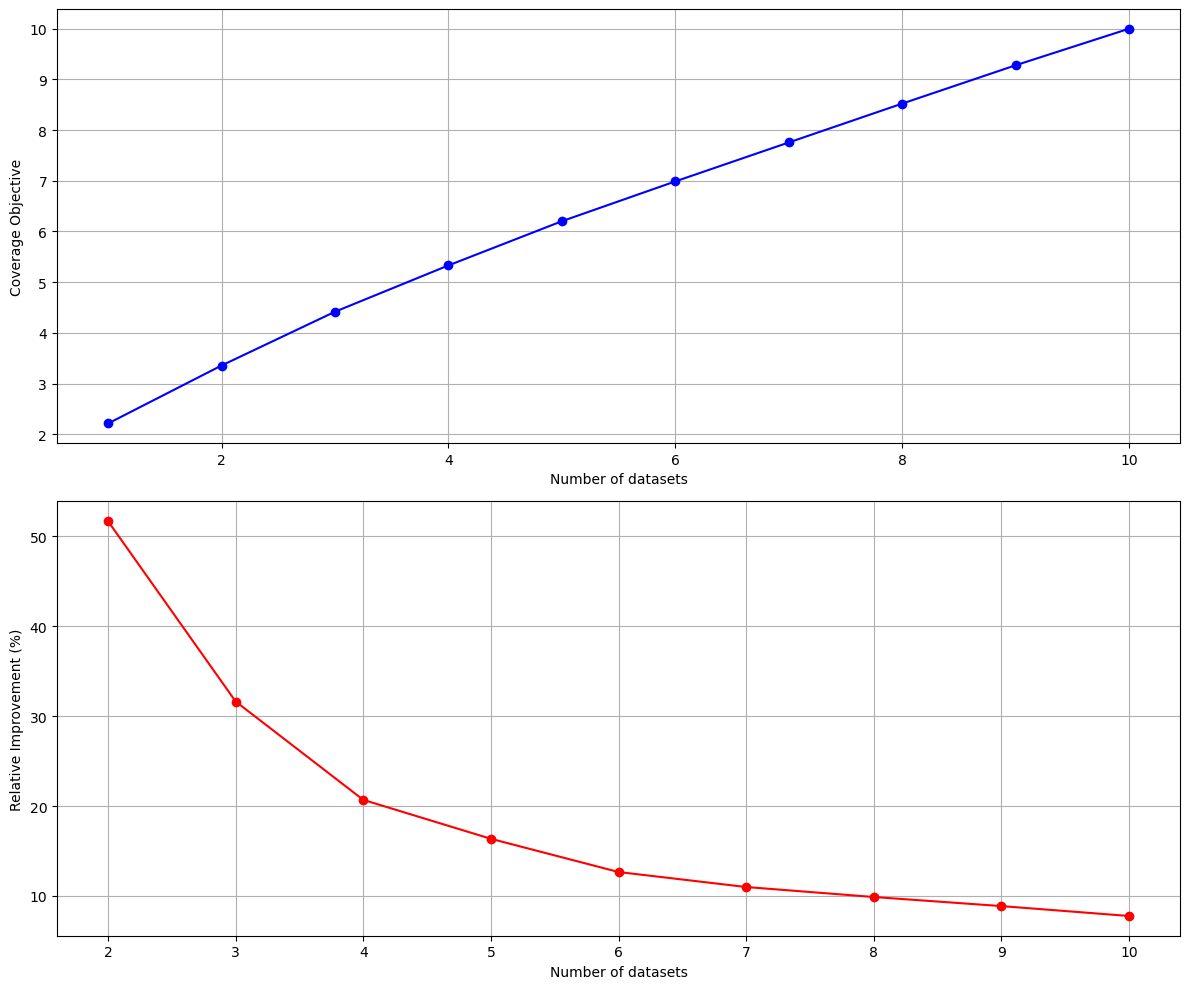

## gpt-4o-0.7-0

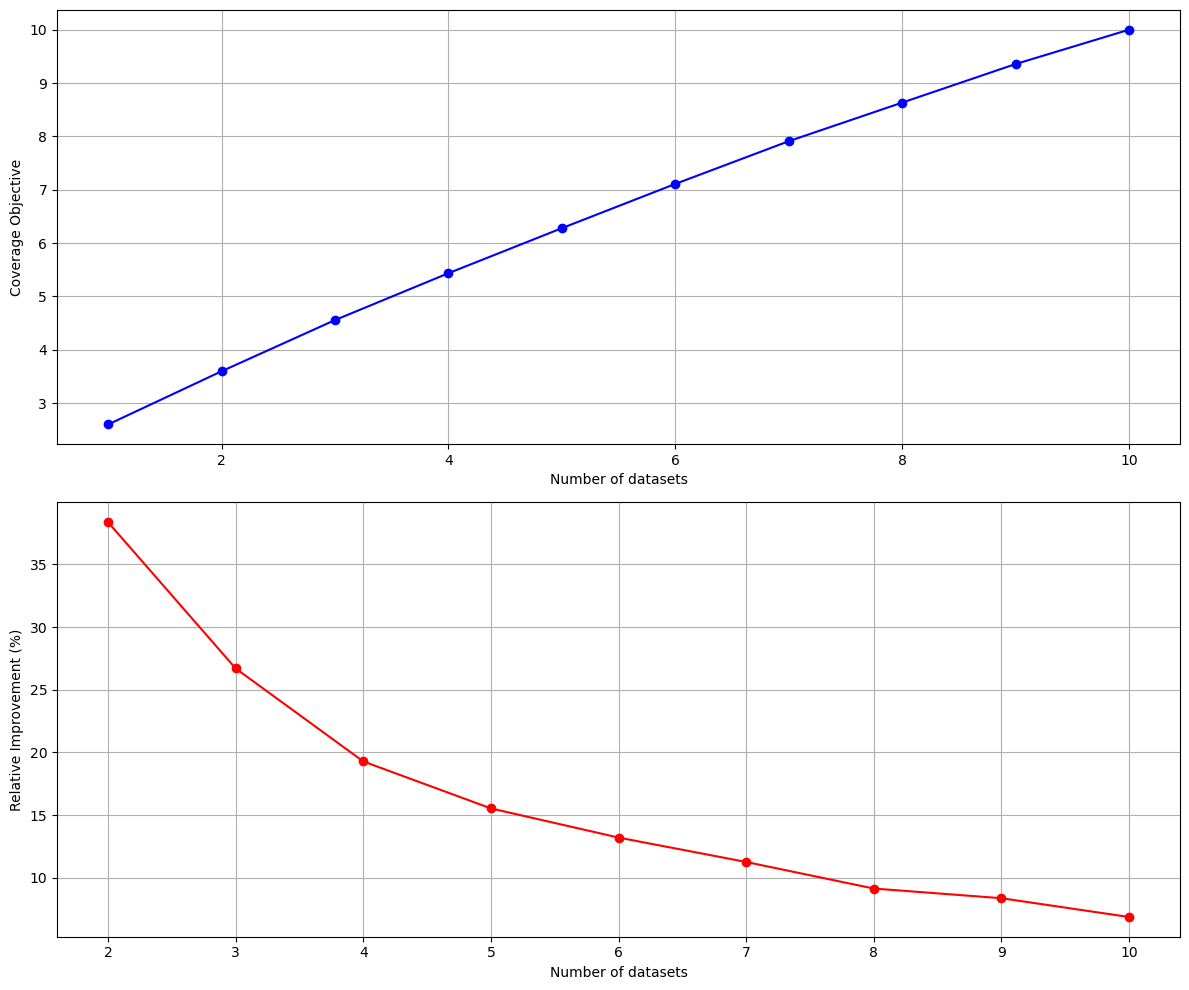

## gpt-4o-1.0-0

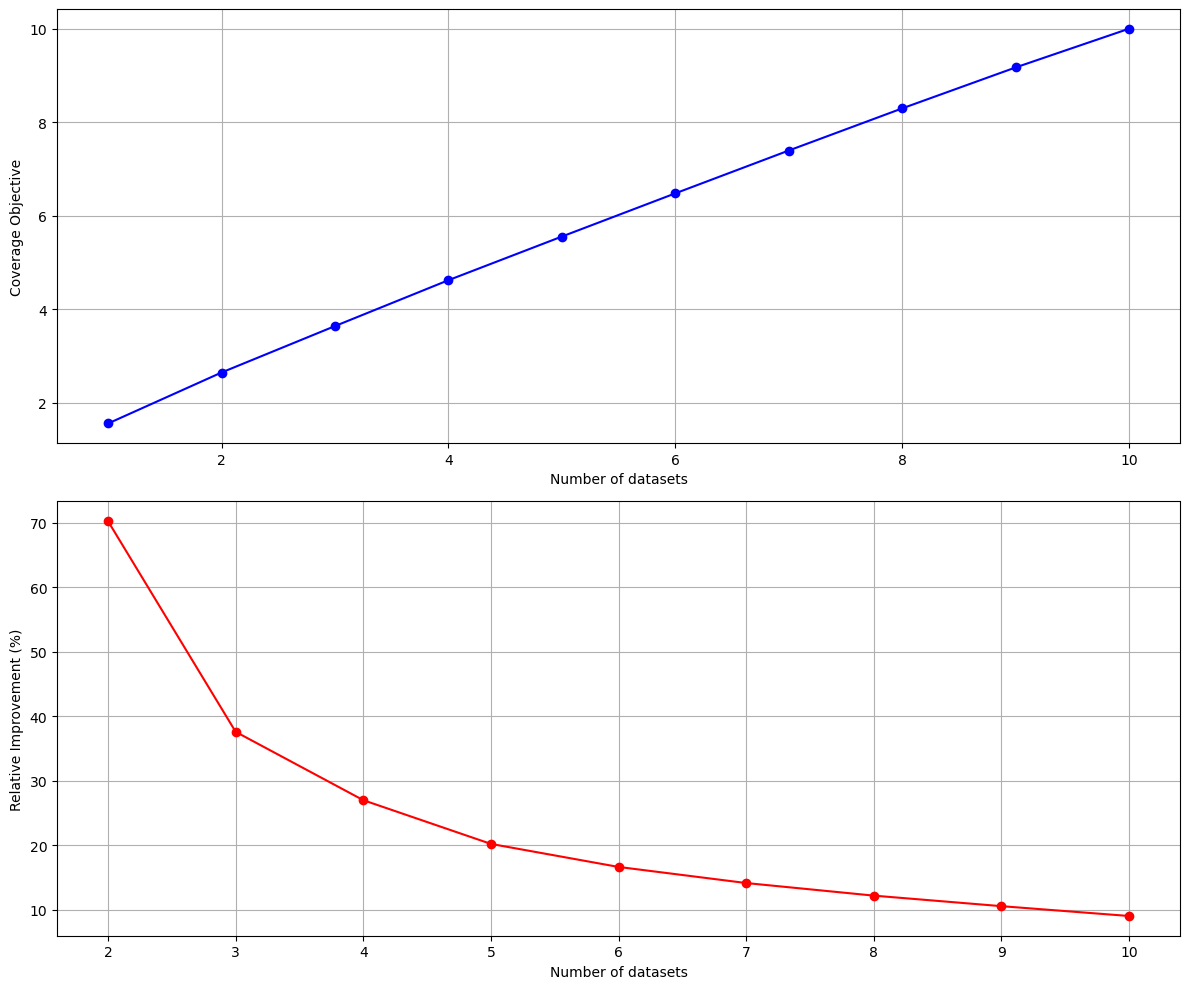

## gpt-4o-mini-0.3-0

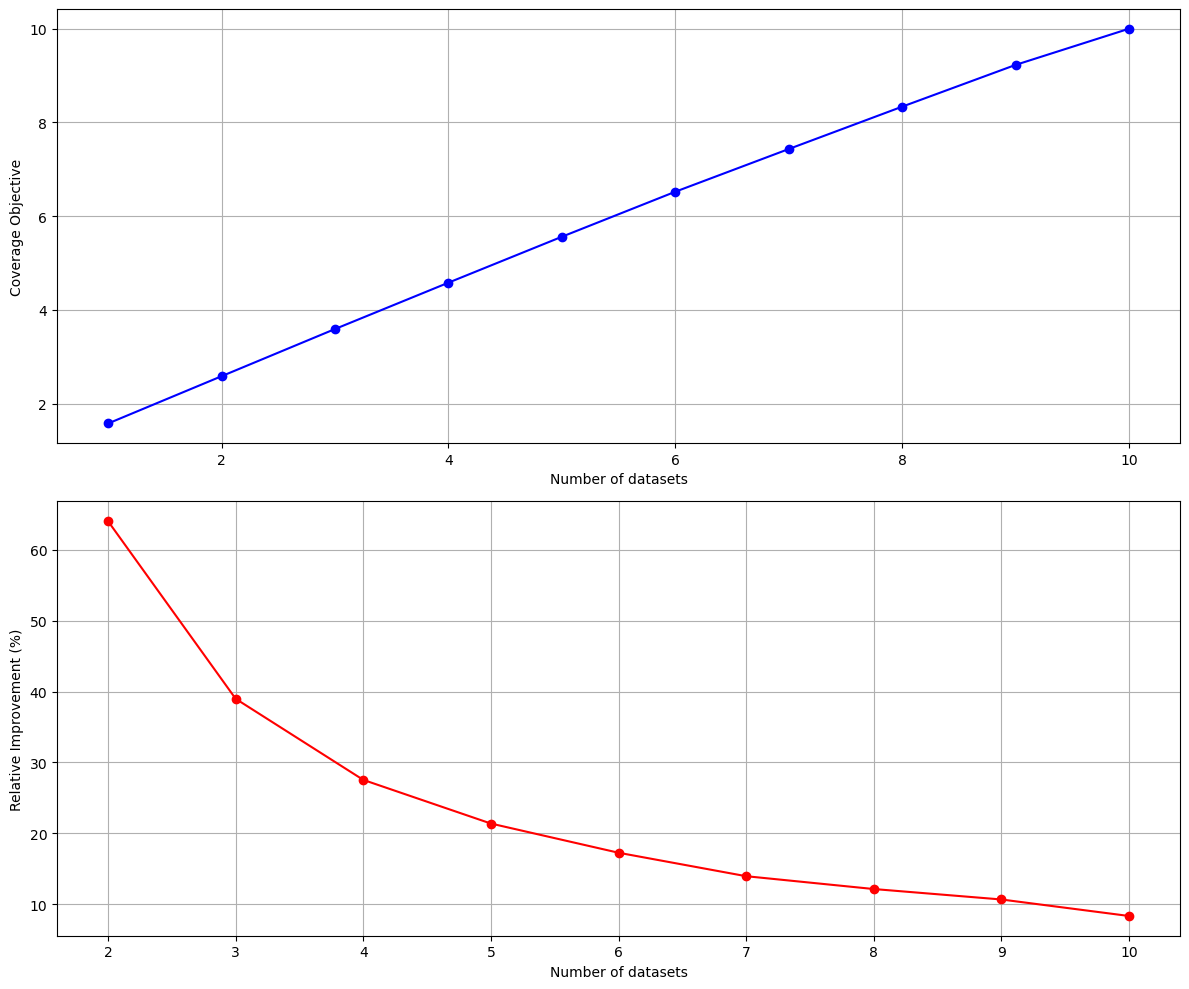

## gpt-4o-mini-0.7-0

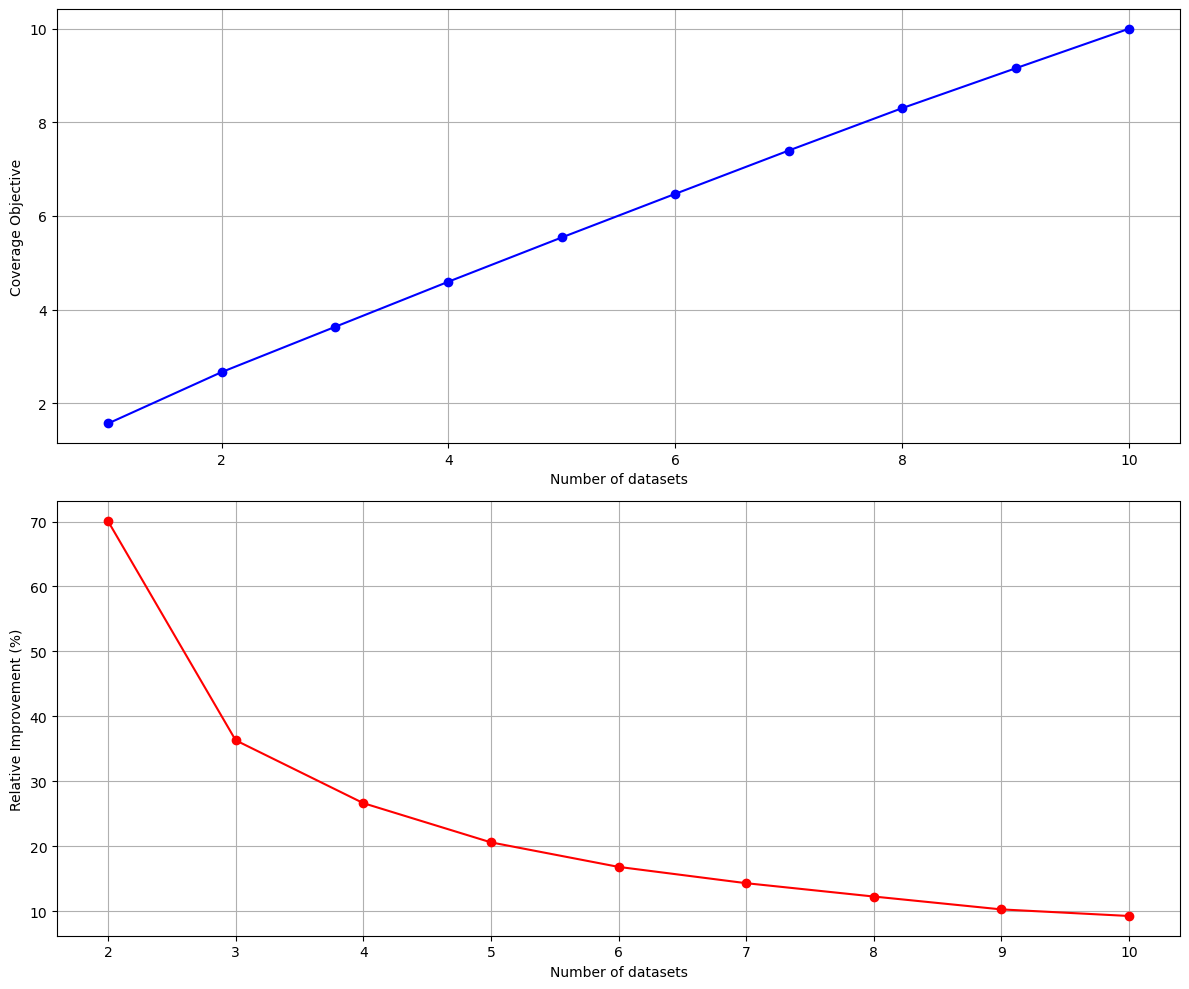

## gpt-4o-mini-1.0-0

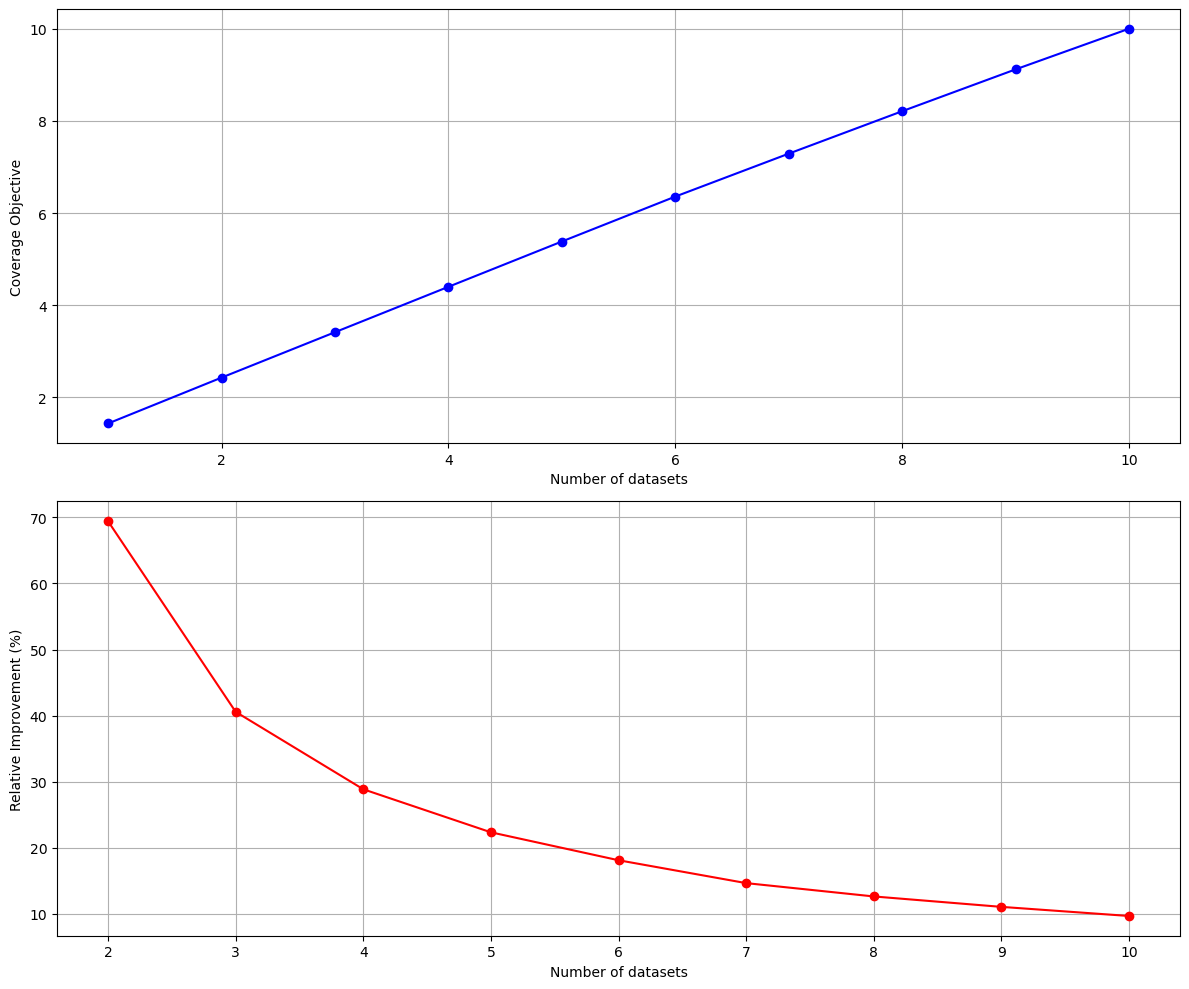

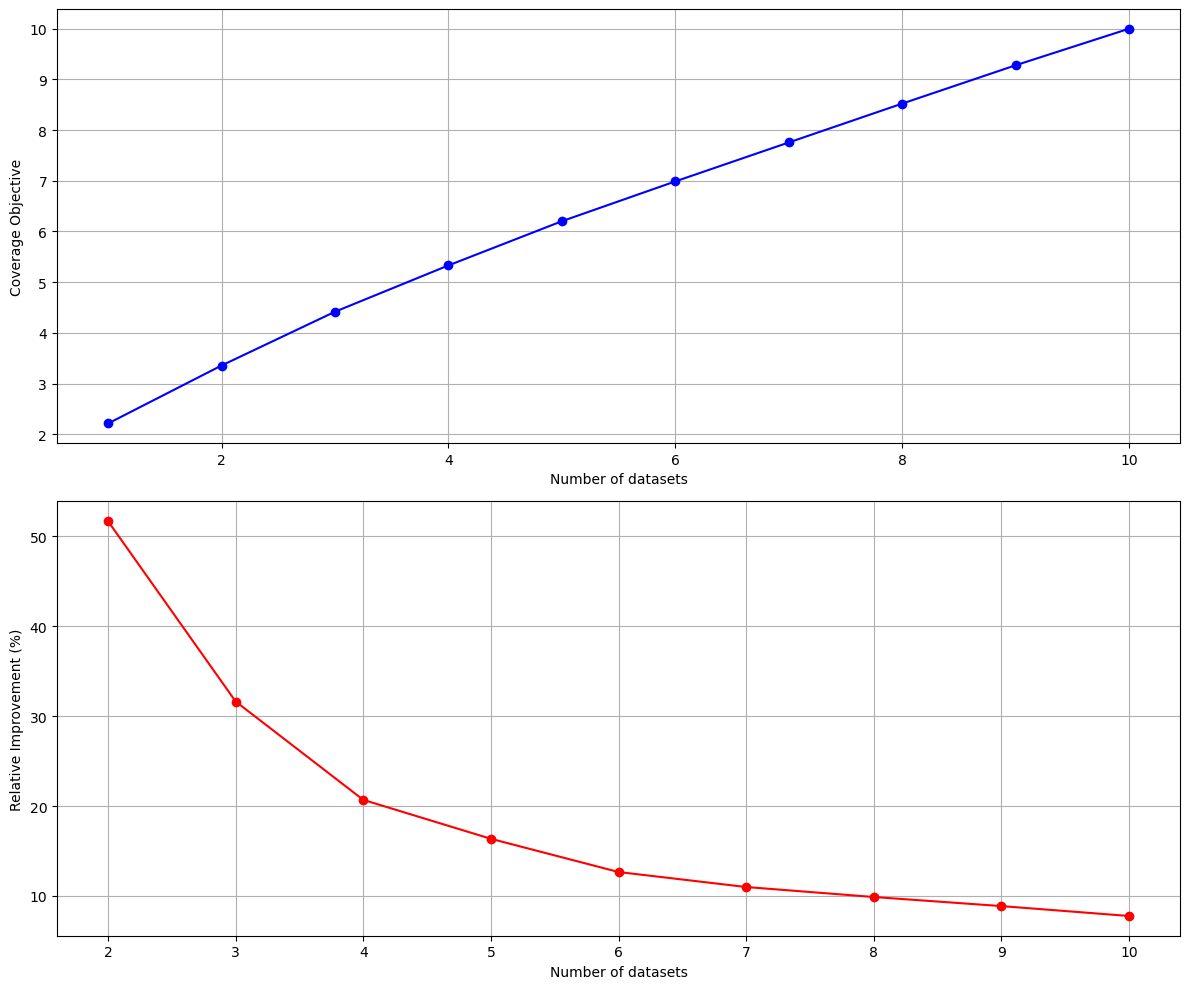

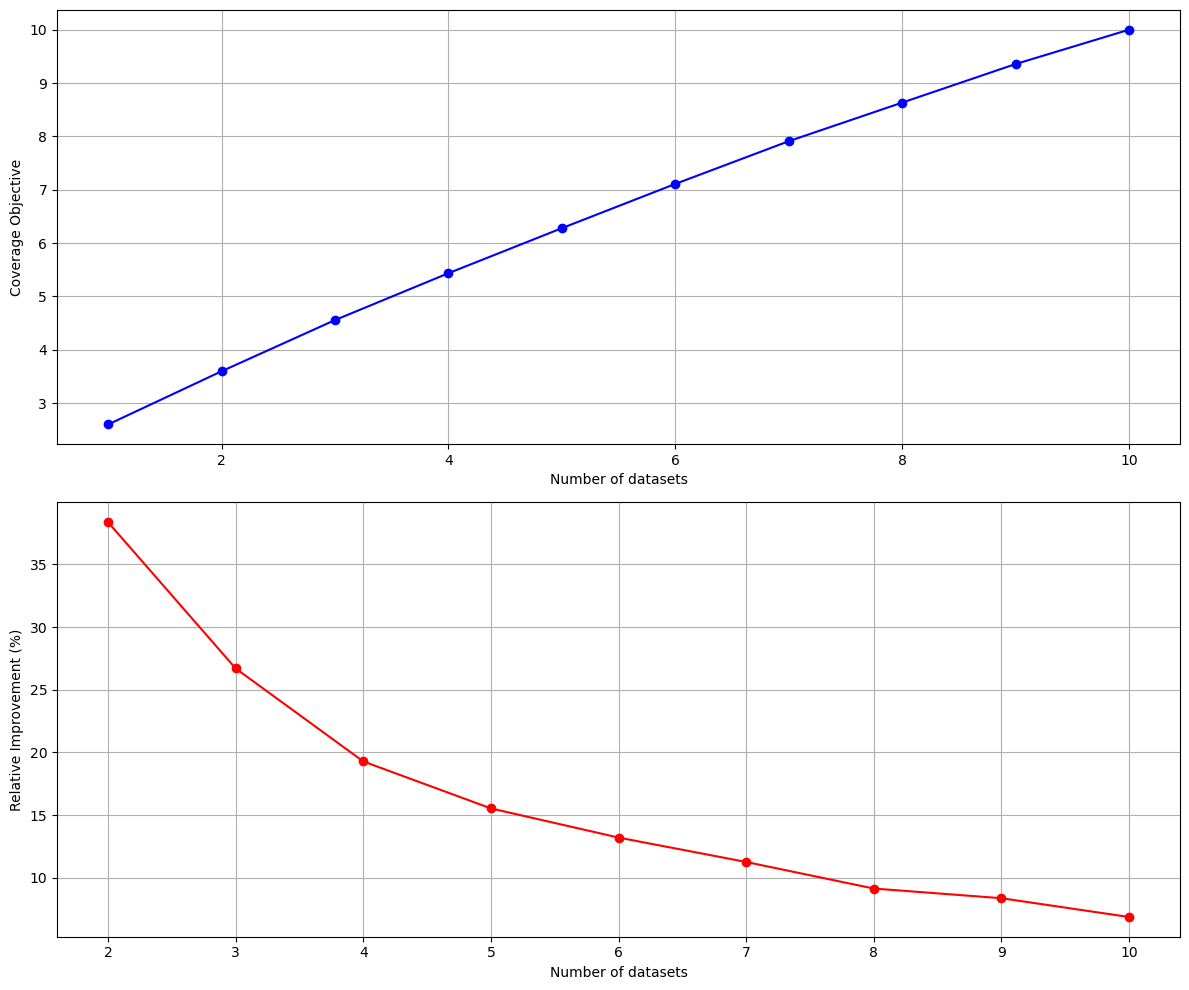

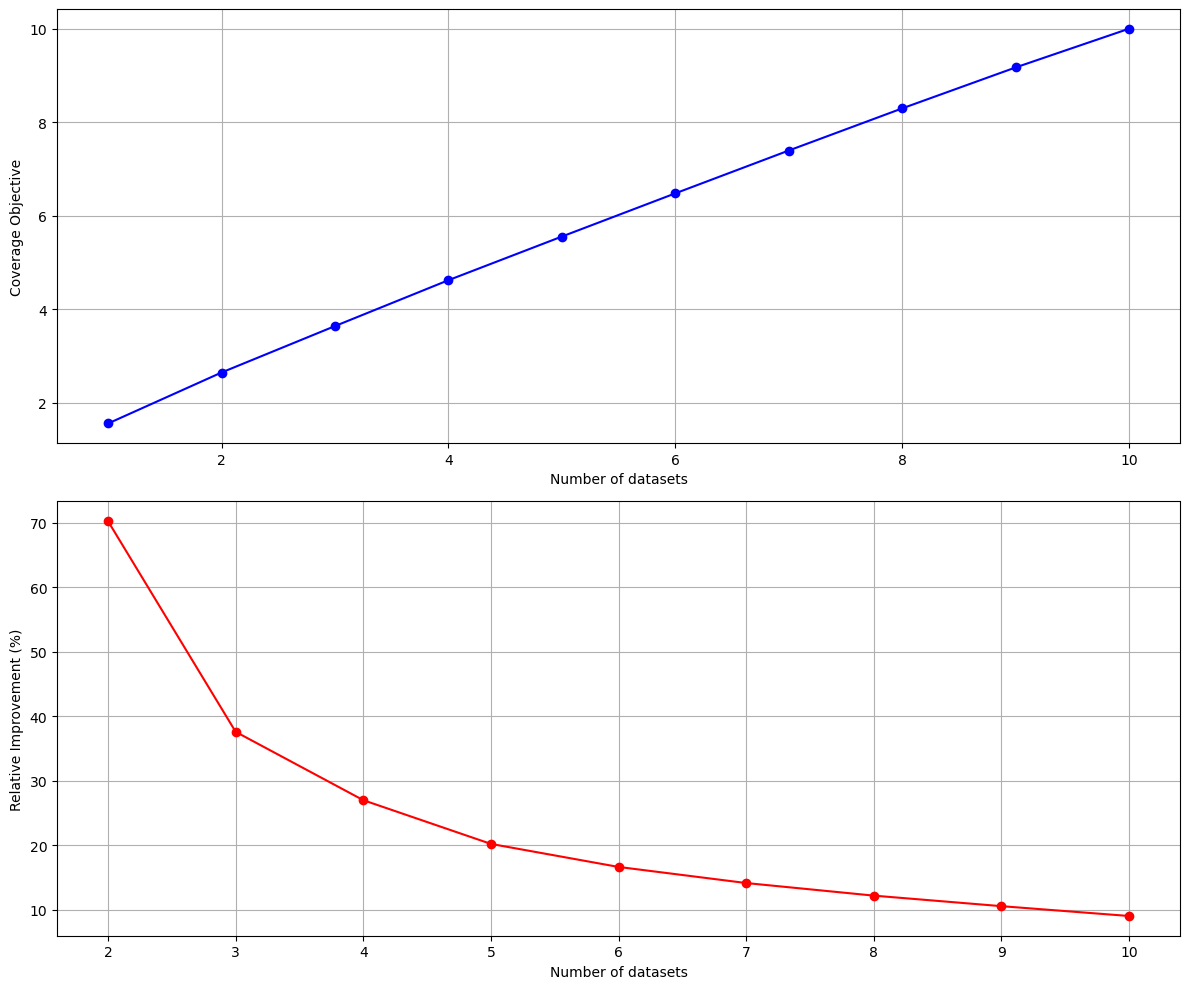

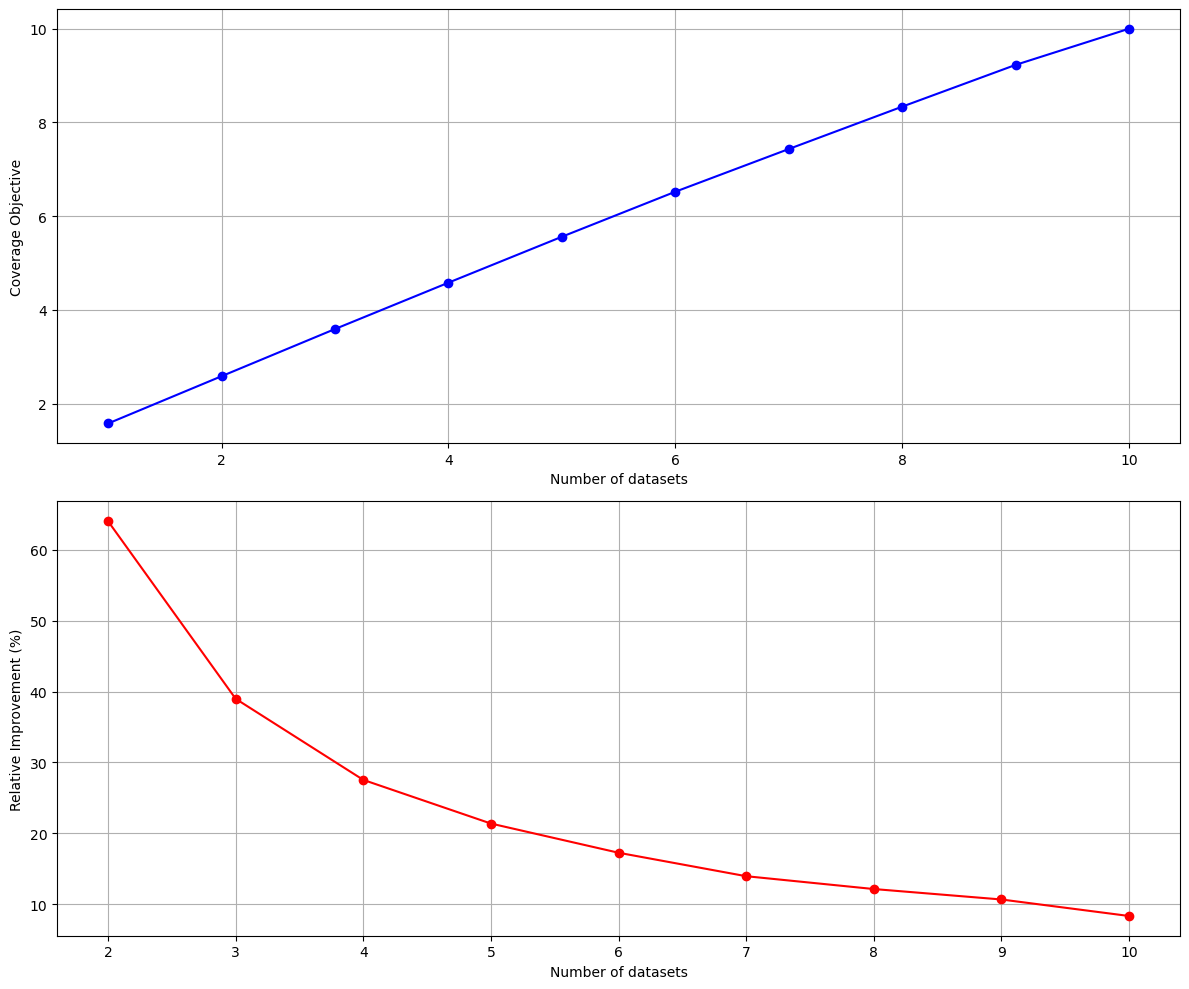

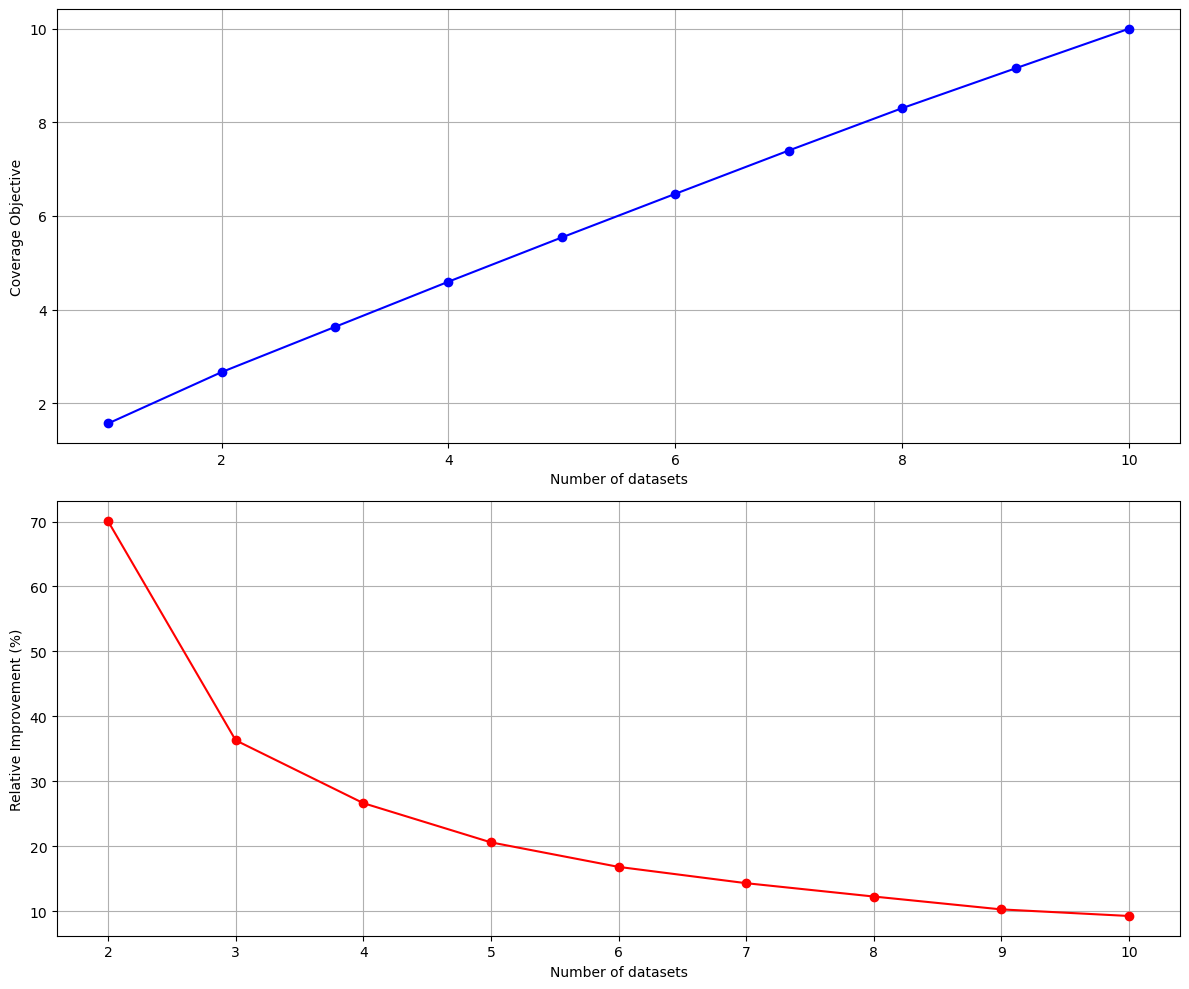

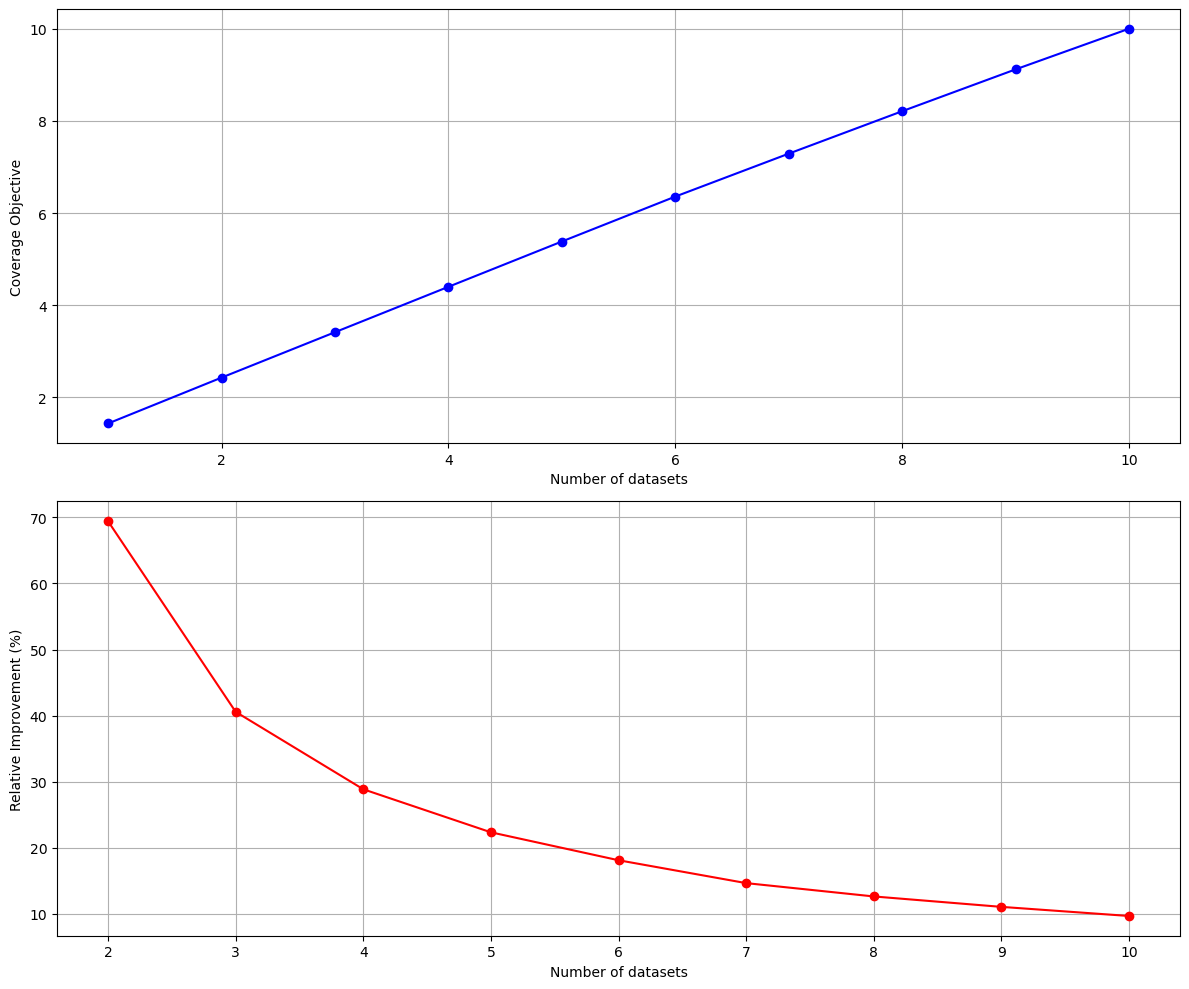

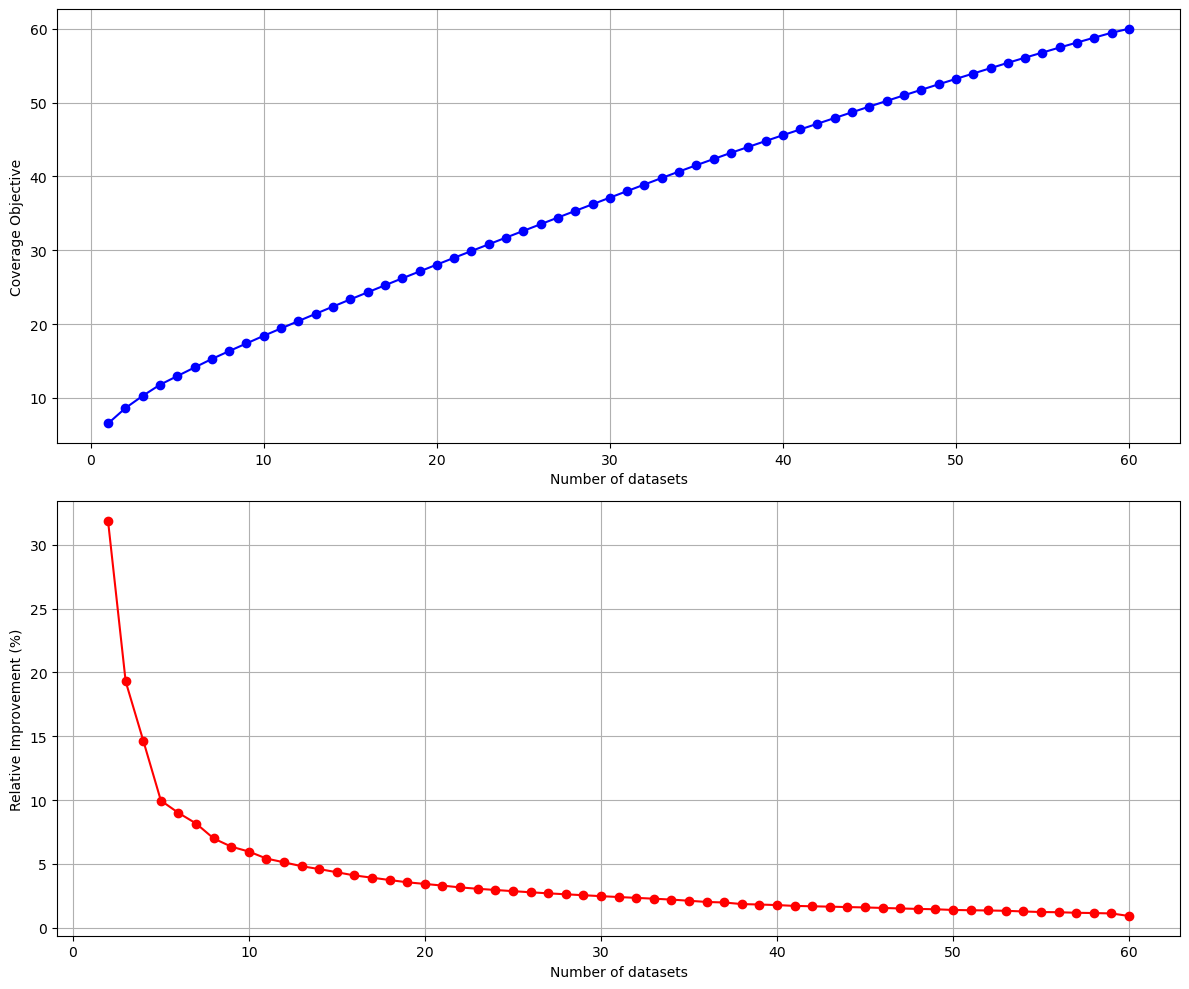

In [5]:
llm_datasets = {}

llm_gorupby = pd.DataFrame(results).groupby(["llm_name", "llm_temperature", "specificaion_version"])

for key, group in llm_gorupby:
    name = "-".join(map(str, key))

    display(Markdown(f"## {name}"))

    group_llm_datasets = {}

    for i, (_, row) in enumerate(group.iterrows()):
        group_llm_datasets[f"{name}-{i}"] = row["dataset"]
    
    fig, _ = plot_dataset_selection(list(group_llm_datasets.values()))
    display(fig)

    llm_datasets |= group_llm_datasets

plot_dataset_selection(list(llm_datasets.values()));

In [6]:
MIXTURE_MAX_COV_OVERALL_NUM_DATASETS = 10
MIXTURE_MAX_COV_PER_GROUP_NUM_DATASETS = 5

mixture_llm_datasets = {
    "MIX-UNIF": mix_datasets(list(llm_datasets.values()), NUM_SAMPLES, "uniform"),
    "MIX-MAX": mix_datasets(list(llm_datasets.values()), NUM_SAMPLES, "max_coverage", MIXTURE_MAX_COV_OVERALL_NUM_DATASETS)

}

for key, group in llm_gorupby:
    name = "-".join(map(str, key))

    mixture_llm_datasets[f"{name}-MIX-UNIF"] = mix_datasets(list(group["dataset"]), NUM_SAMPLES, "uniform")
    mixture_llm_datasets[f"{name}-MIX-MAX"] = mix_datasets(list(group["dataset"]), NUM_SAMPLES, "max_coverage", MIXTURE_MAX_COV_PER_GROUP_NUM_DATASETS)


llm_datasets |= mixture_llm_datasets

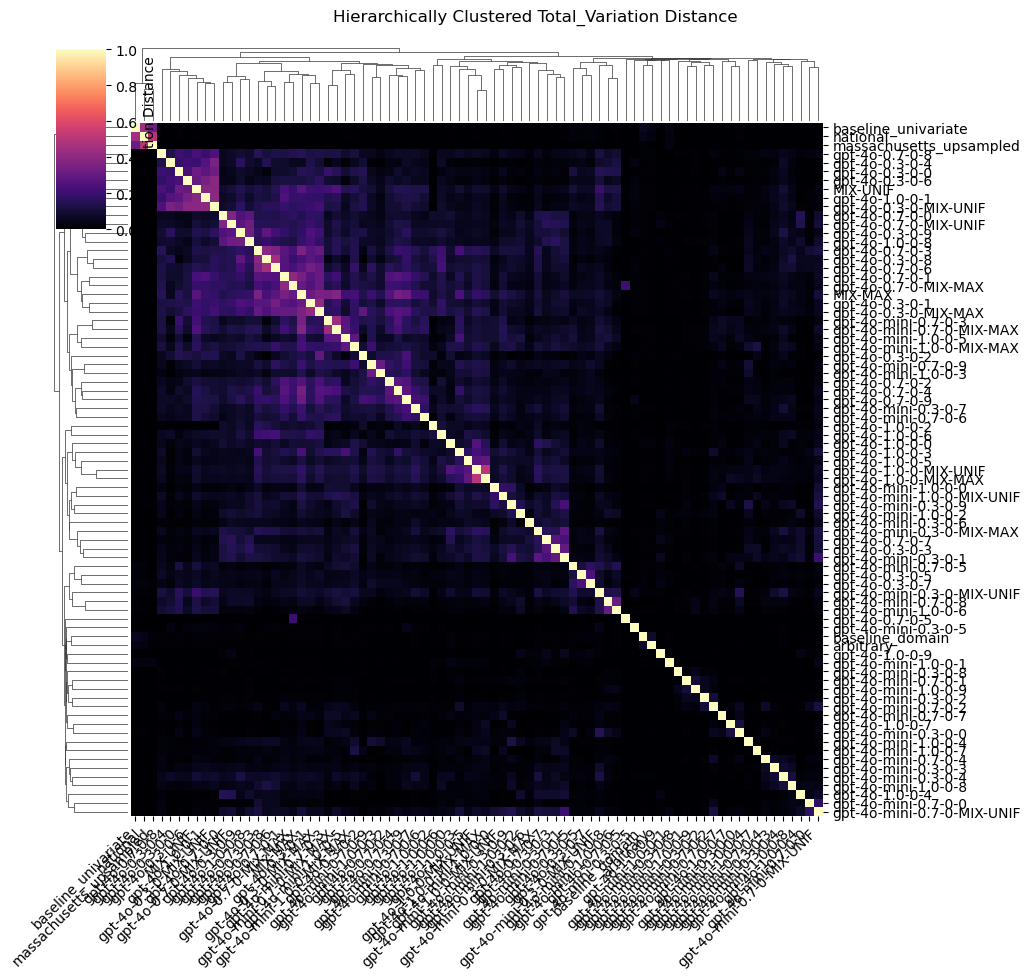

In [7]:
datasets = {
    name.split("/")[1]: load_dataset(name)[0]
    for name in ALL_EXPERIMENTS[FAMILY].dev_names
} | llm_datasets

plot_distribution_distances(datasets)

In [10]:
for name, df in datasets.items():
    if "MIX" in name:
        df.to_csv(f"llm_datasets/{FAMILY}/{name.replace('.','_')}.csv")